In [0]:
Drone imitation learning (modified on martin gorner TPU slides)

In [0]:
import math, re, os, sys
if 'google.colab' in sys.modules: # Colab-only Tensorflow version selector
  %tensorflow_version 2.x
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 2.2.0-rc3


TPU detection

In [0]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.115.144.178:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.115.144.178:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.115.144.178:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


Permission to read bucket

In [0]:
if 'google.colab' in sys.modules:
  from google.colab import auth
  auth.authenticate_user()

In [0]:
IMAGE_SIZE = [512, 512] # At this size, a GPU will run out of memory. Use the TPU.
                        # For GPU training, please select 224 x 224 px image size.
EPOCHS = 25
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
GCS_DS_PATH = 'gs://robot_learning_12'
GCS_PATH_SELECT = { # available image sizes
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: 'gs://robot_learning_12/depth/record'
}
GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]
CHANNELS = 1
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') 

CLASSES = [b'up', b'down', b'stay']

Visualization Utils

In [0]:
# numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    if CHANNELS == 3:
      plt.imshow(image)
    else:
      plt.imshow(image[:, :, 0], cmap="plasma")

    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

Dataset

In [0]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=CHANNELS)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, CHANNELS]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_saturation(image, 0, 2)
    return image, label   

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

print(TRAINING_FILENAMES)
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

['gs://robot_learning_12/depth/record/train/drone00-1715.tfrec', 'gs://robot_learning_12/depth/record/train/drone01-1715.tfrec', 'gs://robot_learning_12/depth/record/train/drone02-1715.tfrec', 'gs://robot_learning_12/depth/record/train/drone03-1715.tfrec', 'gs://robot_learning_12/depth/record/train/drone04-1715.tfrec', 'gs://robot_learning_12/depth/record/train/drone05-1715.tfrec', 'gs://robot_learning_12/depth/record/train/drone06-1715.tfrec', 'gs://robot_learning_12/depth/record/train/drone07-1715.tfrec', 'gs://robot_learning_12/depth/record/train/drone08-1715.tfrec', 'gs://robot_learning_12/depth/record/train/drone09-1715.tfrec', 'gs://robot_learning_12/depth/record/train/drone12-1715.tfrec']
Dataset: 18865 training images, 3430 validation images, 5132 unlabeled test images


Data visualization

In [0]:
print("Training data shapes:")
for image, label in get_training_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())
print("Validation data shapes:")
for image, label in get_validation_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Validation data label examples:", label.numpy())
print("Test data shapes:")
for image, idnum in get_test_dataset().take(3):
    print(image.numpy().shape, idnum.numpy().shape)
print("Test data IDs:", idnum.numpy().astype('U')) # U=unicode string

Training data shapes:
(128, 512, 512, 1) (128,)
(128, 512, 512, 1) (128,)
(128, 512, 512, 1) (128,)
Training data label examples: [2 0 2 ... 0 2 2]
Validation data shapes:
(128, 512, 512, 1) (128,)
(128, 512, 512, 1) (128,)
(128, 512, 512, 1) (128,)
Validation data label examples: [2 2 2 ... 1 2 0]
Test data shapes:
(128, 512, 512, 1) (128,)
(128, 512, 512, 1) (128,)
(128, 512, 512, 1) (128,)
Test data IDs: ['2' '2' '0' ... '1' '2' '1']


In [0]:
# Peek at training data
training_dataset = get_training_dataset()
training_dataset = training_dataset.unbatch().batch(20)
train_batch = iter(training_dataset)

Train peek

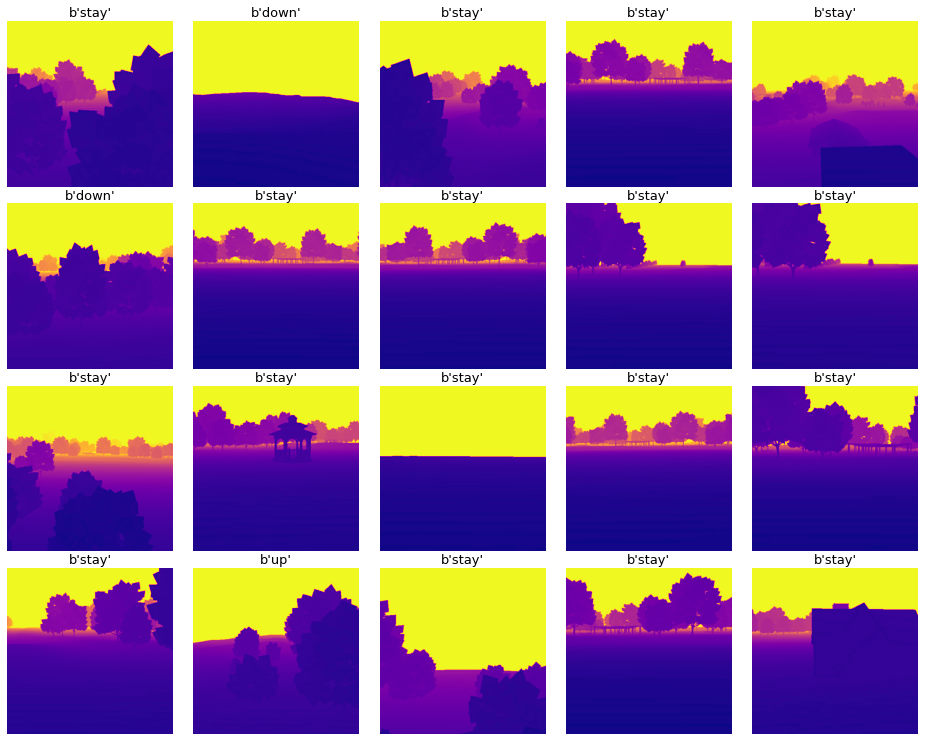

In [0]:
# run this cell again for next set of images
display_batch_of_images(next(train_batch))

Test peek

In [0]:
# peer at test data
test_dataset = get_test_dataset()
test_dataset = test_dataset.unbatch().batch(20)
test_batch = iter(test_dataset)

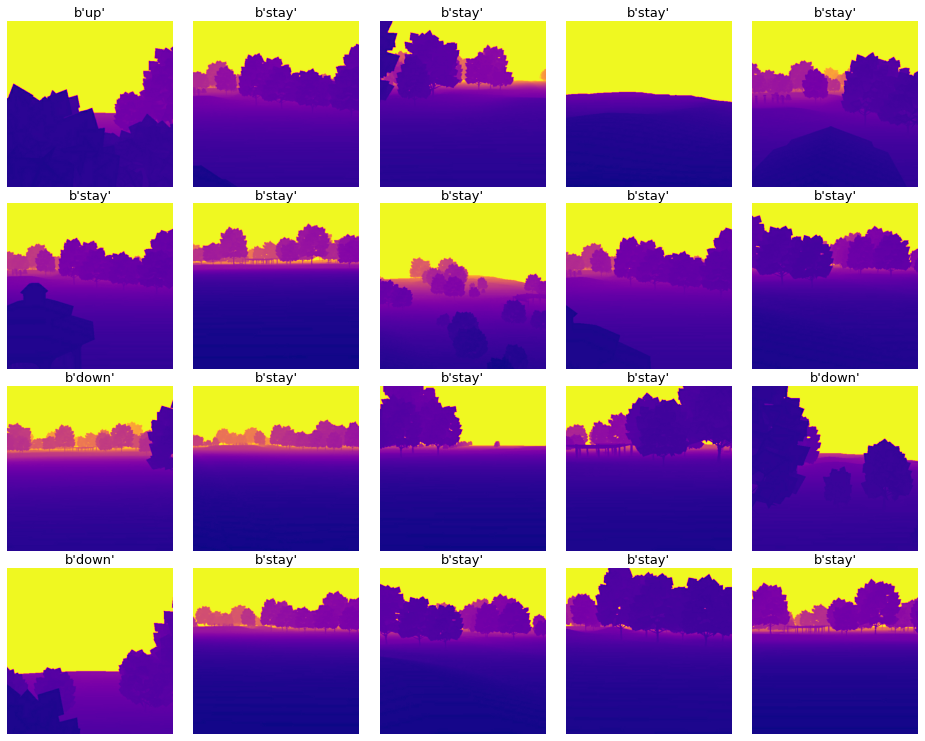

In [0]:
display_batch_of_images(next(test_batch))

Model

In [0]:

with strategy.scope():
  model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(512, 512, 1)),
        tf.keras.layers.Conv2D(32, (3,3), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Conv2D(64,(3,3),activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Conv2D(128,(3,3),activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Dense(32, activation='sigmoid'),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
        
model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 510, 510, 32)      320       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 255, 255, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 253, 253, 64)      18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 126, 126, 64)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 124, 124, 128)     73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 62, 62, 128)       0         
_________________________________________________________________
dense_8 (Dense)              (None, 62, 62, 32)       

VGG16 for RGB images

In [0]:
with strategy.scope():
    pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
    pretrained_model.trainable = False # False = transfer learning, True = fine-tuning
    
    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
        
model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)
model.summary()

In [0]:
filepath="/content/drive/My\ Drive/hdf5/weights-improvement-{epoch:02d}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, period=10)
callbacks_list = [checkpoint]

Training

In [0]:
EPOCHS = 50

history = model.fit(get_training_dataset(), 
                    steps_per_epoch=STEPS_PER_EPOCH, 
                    epochs=EPOCHS, 
                    validation_data=get_validation_dataset())

model.save('depth.h5')

Epoch 1/50
147/147 [==============================] - 26s 174ms/step - loss: 0.5497 - sparse_categorical_accuracy: 0.7987 - val_loss: 0.5648 - val_sparse_categorical_accuracy: 0.7971
Epoch 2/50
147/147 [==============================] - 25s 173ms/step - loss: 0.5487 - sparse_categorical_accuracy: 0.7959 - val_loss: 0.5528 - val_sparse_categorical_accuracy: 0.8035
Epoch 3/50
147/147 [==============================] - 27s 181ms/step - loss: 0.5390 - sparse_categorical_accuracy: 0.8023 - val_loss: 0.5591 - val_sparse_categorical_accuracy: 0.7977
Epoch 4/50
147/147 [==============================] - 26s 175ms/step - loss: 0.5462 - sparse_categorical_accuracy: 0.7981 - val_loss: 0.5581 - val_sparse_categorical_accuracy: 0.8015
Epoch 5/50
147/147 [==============================] - 26s 176ms/step - loss: 0.5442 - sparse_categorical_accuracy: 0.7983 - val_loss: 0.5529 - val_sparse_categorical_accuracy: 0.8064
Epoch 6/50
147/147 [==============================] - 26s 176ms/step - loss: 0.5451 -

Loss 

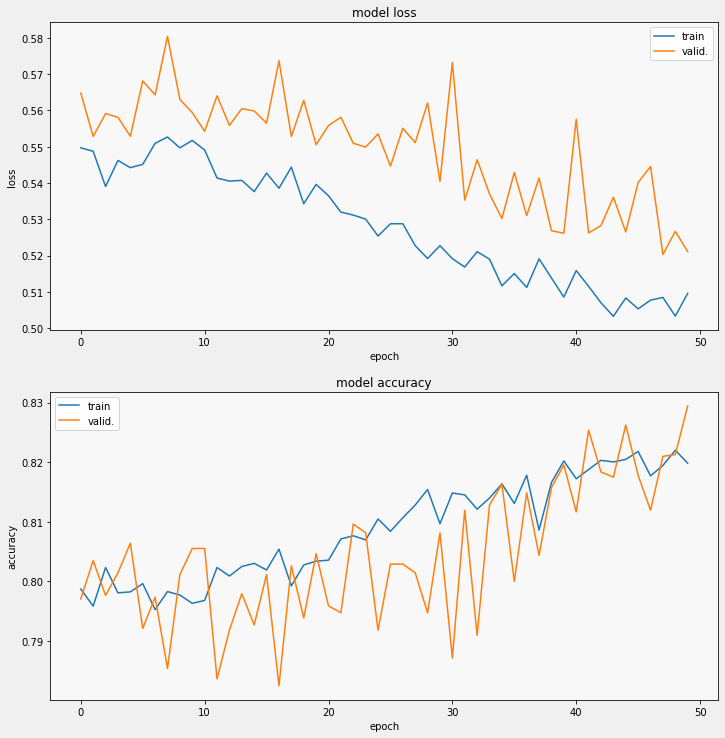

In [0]:
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
display_training_curves(history.history['sparse_categorical_accuracy'], history.history['val_sparse_categorical_accuracy'], 'accuracy', 212)

Predictions

In [0]:
test_ds = get_test_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and ids, order matters.
print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = model.predict(test_images_ds)
predictions = np.argmax(probabilities, axis=-1)
print(predictions.shape)

Computing predictions...
(5132,)


In [0]:
y_true = np.array([])
y_true = y_true.reshape((1, -1))
for image, idnum in get_test_dataset():
    y = idnum.numpy().reshape((1, -1))
    y_true = np.concatenate((y_true, y), axis=None)

In [0]:
from sklearn.metrics import accuracy_score
y_pred = predictions
acc = accuracy_score(y_true, y_pred)
print(acc)

0.5212392829306314


Visual validation

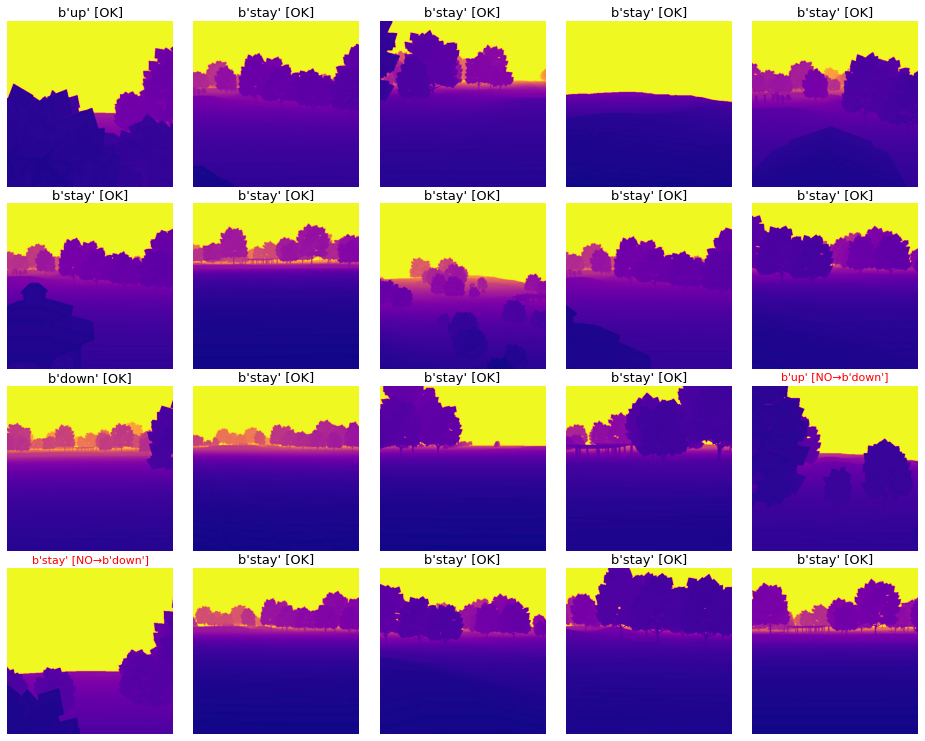

In [0]:
dataset = get_test_dataset()
dataset = dataset.unbatch().batch(20)
batch = iter(dataset)

# run this cell again for next set of images
images, labels = next(batch)
probabilities = model.predict(images)
predictions = np.argmax(probabilities, axis=-1)
display_batch_of_images((images, labels), predictions)